HRNet with Self Attention

Mounted at /content/drive
1160 1160
Found 1160 images.
Found 1160 mask files.
Epoch 1/75
87/87 [==============================] - 680s 7s/step - loss: 0.2007 - accuracy: 0.9760 - val_loss: 0.0654 - val_accuracy: 0.9770
Epoch 2/75
87/87 [==============================] - 35s 405ms/step - loss: 0.0643 - accuracy: 0.9769 - val_loss: 0.0533 - val_accuracy: 0.9770
Epoch 3/75
87/87 [==============================] - 37s 420ms/step - loss: 0.0823 - accuracy: 0.9775 - val_loss: 0.0866 - val_accuracy: 0.9770
Epoch 4/75
87/87 [==============================] - 37s 428ms/step - loss: 0.0674 - accuracy: 0.9771 - val_loss: 0.0562 - val_accuracy: 0.9797
Epoch 5/75
87/87 [==============================] - 38s 437ms/step - loss: 0.0568 - accuracy: 0.9805 - val_loss: 0.0491 - val_accuracy: 0.9831
Epoch 6/75
87/87 [==============================] - 37s 423ms/step - loss: 0.0542 - accuracy: 0.9783 - val_loss: 0.0554 - val_accuracy: 0.9779
Epoch 7/75
87/87 [==============================] - 37s 425ms/step

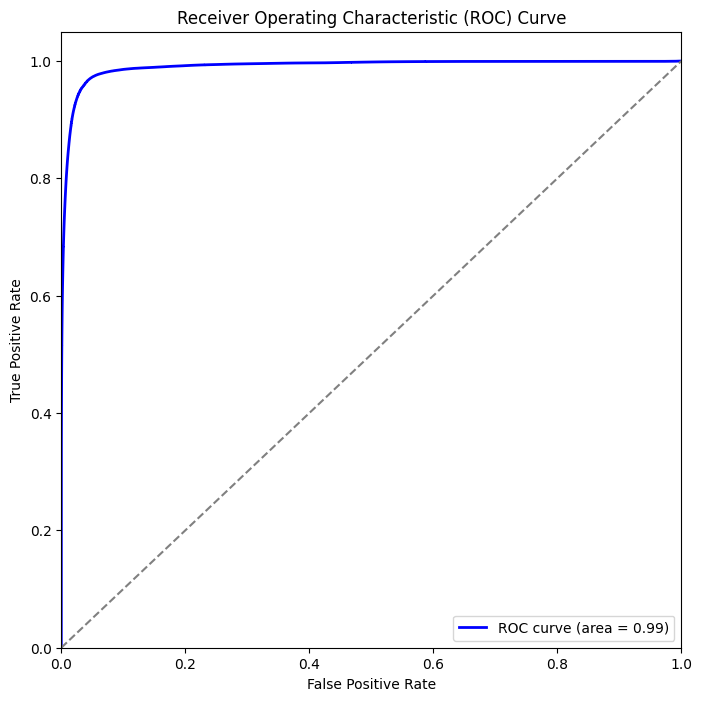

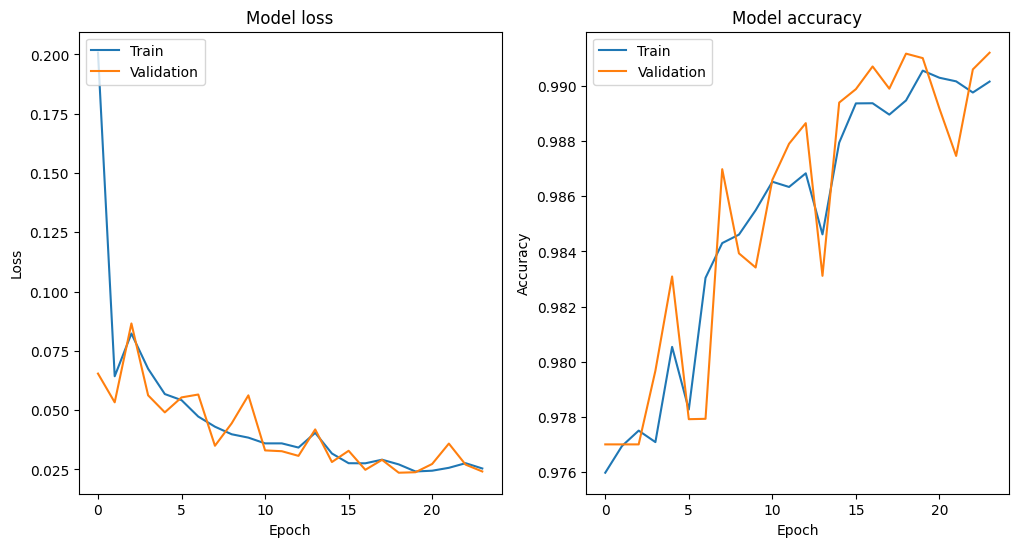

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dense, Layer, Permute, Reshape, Multiply
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.callbacks import EarlyStopping
import xml.etree.ElementTree as ET

from google.colab import drive
drive.mount('/content/drive')

images_path = '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages'
masks_path = '/content/drive/MyDrive/BBox_SSDD/voc_style/Annotations'

if not os.path.exists(images_path):
    raise ValueError(f"Images directory '{images_path}' not found.")

if not os.path.exists(masks_path):
    raise ValueError(f"Masks directory '{masks_path}' not found.")

images = sorted([os.path.join(images_path, file) for file in os.listdir(images_path) if file.endswith('.jpg')])
mask_files = sorted([os.path.join(masks_path, f) for f in os.listdir(masks_path) if f.endswith('.xml')])

print(len(images), len(mask_files))

if len(mask_files) == 0:
    raise ValueError("No mask files found in the specified directory. Please check your mask directory.")

print(f"Found {len(images)} images.")
print(f"Found {len(mask_files)} mask files.")

train_images, test_images, train_masks, test_masks = train_test_split(images, mask_files, test_size=0.4, random_state=42)
val_images, test_images, val_masks, test_masks = train_test_split(test_images, test_masks, test_size=0.5, random_state=42)

def adjust_data(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img, mask)

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images_paths, masks_paths, batch_size=8, image_size=(256, 256)):
        self.images_paths = images_paths
        self.masks_paths = masks_paths
        self.batch_size = batch_size
        self.image_size = image_size

    def __len__(self):
        return len(self.images_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_x = self.images_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.masks_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        x = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.float32)
        y = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.float32)

        for i, (img_path, mask_path) in enumerate(zip(batch_x, batch_y)):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            mask = np.zeros_like(img, dtype=np.uint8)

            tree = ET.parse(mask_path)
            root = tree.getroot()
            for obj in root.findall('object'):
                bndbox = obj.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                cv2.rectangle(mask, (xmin, ymin), (xmax, ymax), (255), thickness=-1)

            img = cv2.resize(img, self.image_size)
            mask = cv2.resize(mask, self.image_size)

            img = np.expand_dims(img, axis=-1)
            mask = np.expand_dims(mask, axis=-1)

            x[i], y[i] = adjust_data(img, mask)

        return x, y

class SelfAttention(Layer):
    def __init__(self, units):
        super(SelfAttention, self).__init__()
        self.units = units
        self.wq = Dense(units)
        self.wk = Dense(units)
        self.wv = Dense(units)
        self.dense = Dense(units)

    def call(self, inputs):
        q = self.wq(inputs)
        k = self.wk(inputs)
        v = self.wv(inputs)

        matmul_qk = tf.matmul(q, k, transpose_b=True)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(tf.cast(self.units, tf.float32))
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)

        return self.dense(output)

def hrnet_model_with_self_attention(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    maxpool1 = MaxPooling2D()(conv2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(maxpool1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    maxpool2 = MaxPooling2D()(conv4)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(maxpool2)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

    self_attention_1 = SelfAttention(256)
    self_attended_1 = self_attention_1(conv6)
    conv6_attended = tf.keras.layers.add([conv6, self_attended_1])

    maxpool3 = MaxPooling2D()(conv6_attended)
    conv7 = Conv2D(512, 3, activation='relu', padding='same')(maxpool3)
    conv8 = Conv2D(512, 3, activation='relu', padding='same')(conv7)

    self_attention_2 = SelfAttention(512)
    self_attended_2 = self_attention_2(conv8)
    conv8_attended = tf.keras.layers.add([conv8, self_attended_2])

    upsample1 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv8_attended)
    concat1 = concatenate([upsample1, conv6], axis=3)
    conv9 = Conv2D(256, 3, activation='relu', padding='same')(concat1)
    conv10 = Conv2D(256, 3, activation='relu', padding='same')(conv9)
    upsample2 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv10)
    concat2 = concatenate([upsample2, conv4], axis=3)
    conv11 = Conv2D(128, 3, activation='relu', padding='same')(concat2)
    conv12 = Conv2D(128, 3, activation='relu', padding='same')(conv11)
    upsample3 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv12)
    concat3 = concatenate([upsample3, conv2], axis=3)
    conv13 = Conv2D(64, 3, activation='relu', padding='same')(concat3)
    conv14 = Conv2D(64, 3, activation='relu', padding='same')(conv13)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv14)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

model_with_self_attention = hrnet_model_with_self_attention(input_size=(256, 256, 1))

batch_size = 8

train_gen = DataGenerator(train_images, train_masks, batch_size=batch_size)
val_gen = DataGenerator(val_images, val_masks, batch_size=batch_size)
test_gen = DataGenerator(test_images, test_masks, batch_size=batch_size)

history_self_attention = model_with_self_attention.fit(train_gen,
                                            epochs=75,
                                            validation_data=val_gen,
                                            callbacks=[early_stopping])

y_pred_self_attention = model_with_self_attention.predict(test_gen)

y_true_flat_self_attention = np.concatenate([test_gen[i][1].flatten() for i in range(len(test_gen))])
y_pred_flat_self_attention = y_pred_self_attention.flatten()

y_pred_binary_self_attention = (y_pred_flat_self_attention > 0.5).astype(int)

fpr_self_attention, tpr_self_attention, thresholds_self_attention = roc_curve(y_true_flat_self_attention, y_pred_flat_self_attention)

roc_auc_self_attention = auc(fpr_self_attention, tpr_self_attention)

plt.figure(figsize=(8, 8))
plt.plot(fpr_self_attention, tpr_self_attention, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_self_attention:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_self_attention.history['loss'])
plt.plot(history_self_attention.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_self_attention.history['accuracy'])
plt.plot(history_self_attention.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score
from sklearn.metrics import precision_score, recall_score
import math

def compute_iou_masks(y_true, y_pred):
    intersection_area = 0
    union_area = 0

    for mask_true, mask_pred in zip(y_true, y_pred):
        intersection = np.logical_and(mask_true, mask_pred)
        union = np.logical_or(mask_true, mask_pred)

        intersection_area += np.sum(intersection)
        union_area += np.sum(union)

    if union_area == 0:
        return 0

    return intersection_area / union_area

def compute_map_boxes(y_true, y_pred):
    avg_precision = 0

    for i in range(len(y_true)):
        y_true_flat = y_true[i].flatten()
        y_pred_flat = y_pred[i].flatten()

        precision, recall, _ = precision_recall_curve(y_true_flat, y_pred_flat)

        avg_precision += average_precision_score(y_true_flat, y_pred_flat)

    return avg_precision / len(y_true)


def compute_psnr_boxes(y_true, y_pred):
    mse_total = 0
    num_samples = len(y_true)

    for box_true, box_pred in zip(y_true, y_pred):
        mse = np.mean((box_true - box_pred) ** 2)
        mse_total += mse

    mse_avg = mse_total / num_samples

    if mse_avg == 0:
        return float('inf')
    else:
        max_pixel = 1.0
        return 20 * math.log10(max_pixel / math.sqrt(mse_avg))


def compute_dice_boxes(y_true, y_pred):
    dice_scores = []

    for box_true, box_pred in zip(y_true, y_pred):
        intersection = np.sum(box_true * box_pred)
        dice = (2. * intersection) / (np.sum(box_true) + np.sum(box_pred))
        dice_scores.append(dice)

    return np.mean(dice_scores)


test_gen_no_shuffle = DataGenerator(test_images, test_masks, batch_size=batch_size)

y_true_self_attention = []
for i in range(len(test_gen_no_shuffle)):
    _, batch_y = test_gen_no_shuffle[i]
    y_true_self_attention.extend(batch_y)

y_true_self_attention = np.array(y_true_self_attention)

if y_true_self_attention.shape != y_true_self_attention.shape:
    raise ValueError("Shapes of y_pred_new and y_true_new are not compatible.")


iou_boxes_self_attention = compute_iou_masks(y_true_self_attention, y_pred_self_attention)
mAP_boxes_self_attention = compute_map_boxes(y_true_self_attention, y_pred_self_attention)
psnr_boxes_self_attention = compute_psnr_boxes(y_true_self_attention, y_pred_self_attention)
dice_boxes_self_attention = compute_dice_boxes(y_true_self_attention, y_pred_self_attention)

print("Intersection over Union (IoU) for Segmentation Boxes for the self attention model:", iou_boxes_self_attention)
print("Mean Average Precision (mAP) for Segmentation Boxes for the self attention model:", mAP_boxes_self_attention)
print("Peak Signal to Noise Ratio (PSNR) for Segmentation Boxes for the self attention model:", psnr_boxes_self_attention)
print("Dice Coefficient for Segmentation Boxes for the self attention model:", dice_boxes_self_attention)

Intersection over Union (IoU) for Segmentation Boxes for the self attention model: 0.02524810001767915
Mean Average Precision (mAP) for Segmentation Boxes for the self attention model: 0.9290785356070168
Peak Signal to Noise Ratio (PSNR) for Segmentation Boxes for the self attention model: 20.697179555064093
Dice Coefficient for Segmentation Boxes for the self attention model: 0.7205130914937438


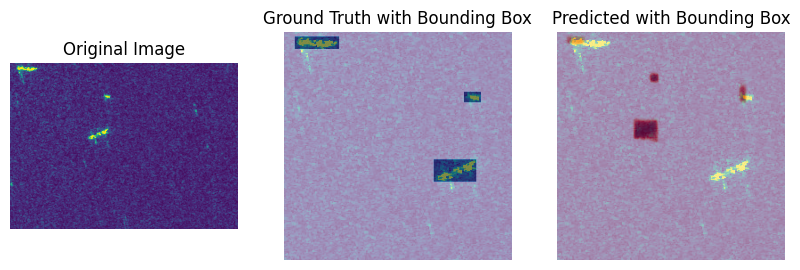

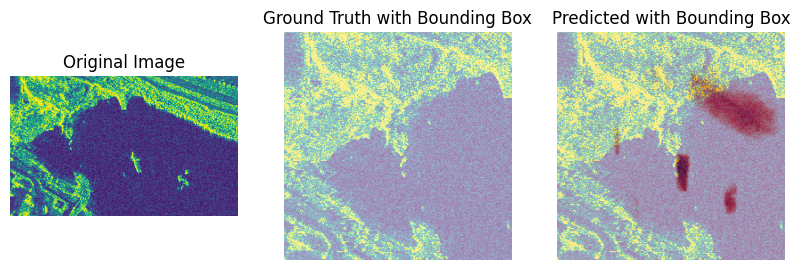

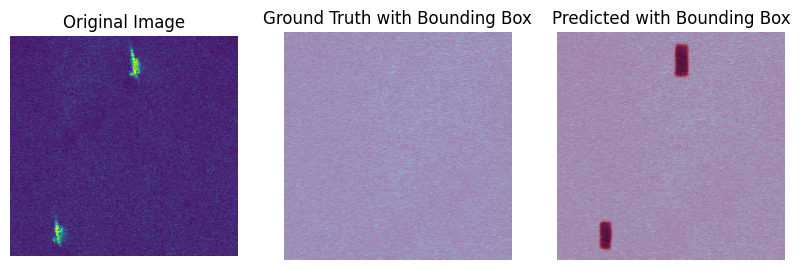

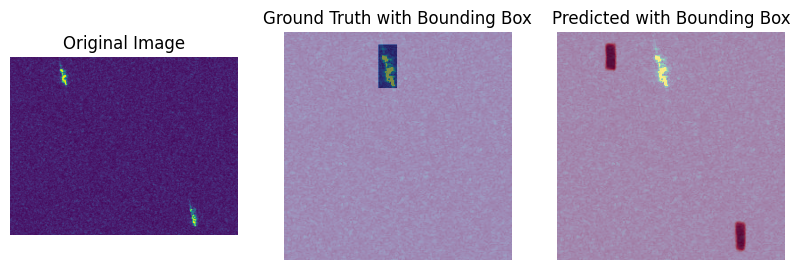

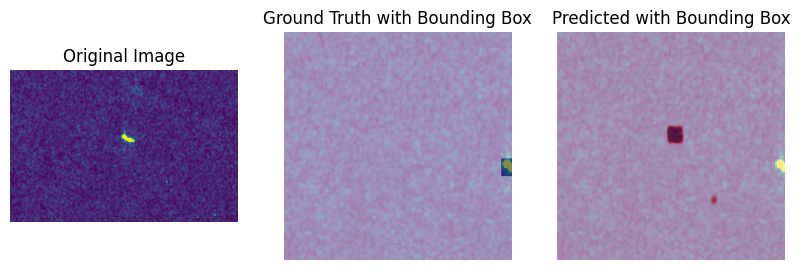

In [ ]:
import matplotlib.pyplot as plt

def create_segmentation_masks(xml_path, image_size):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    mask = np.zeros(image_size, dtype=np.uint8)

    for obj in root.findall('object'):
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        mask[ymin:ymax, xmin:xmax] = 1

    return mask

def visualize_bounding_boxes(images, masks, predictions):
    num_images = len(images)

    for i in range(num_images):
        image = images[i]
        mask = masks[i]
        prediction = predictions[i]

        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
        mask = create_segmentation_masks(mask, (256, 256))
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(image)
        plt.imshow(mask, alpha=0.5, cmap='Blues')
        plt.title("Ground Truth with Bounding Box")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(image)
        plt.imshow(prediction, alpha=0.5, cmap='Reds')
        plt.title("Predicted with Bounding Box")
        plt.axis('off')

        plt.show()

visualize_bounding_boxes(test_images[:5], test_masks[:5], y_pred_self_attention[:5])

HRNet with Multi-head Attention

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1160 1160
Found 1160 images.
Found 1160 mask files.
Epoch 1/75
87/87 [==============================] - 82s 759ms/step - loss: 0.1588 - accuracy: 0.9665 - val_loss: 0.0774 - val_accuracy: 0.9770
Epoch 2/75
87/87 [==============================] - 66s 762ms/step - loss: 0.0770 - accuracy: 0.9775 - val_loss: 0.0857 - val_accuracy: 0.9775
Epoch 3/75
87/87 [==============================] - 66s 762ms/step - loss: 0.0690 - accuracy: 0.9780 - val_loss: 0.0694 - val_accuracy: 0.9770
Epoch 4/75
87/87 [==============================] - 66s 762ms/step - loss: 0.0648 - accuracy: 0.9779 - val_loss: 0.0612 - val_accuracy: 0.9787
Epoch 5/75
87/87 [==============================] - 69s 799ms/step - loss: 0.0641 - accuracy: 0.9779 - val_loss: 0.0605 - val_accuracy: 0.9771
Epoch 6/75
87/87 [==============================] - 67s 765ms/step - loss: 0.0604 - accuracy: 0.9789 - v

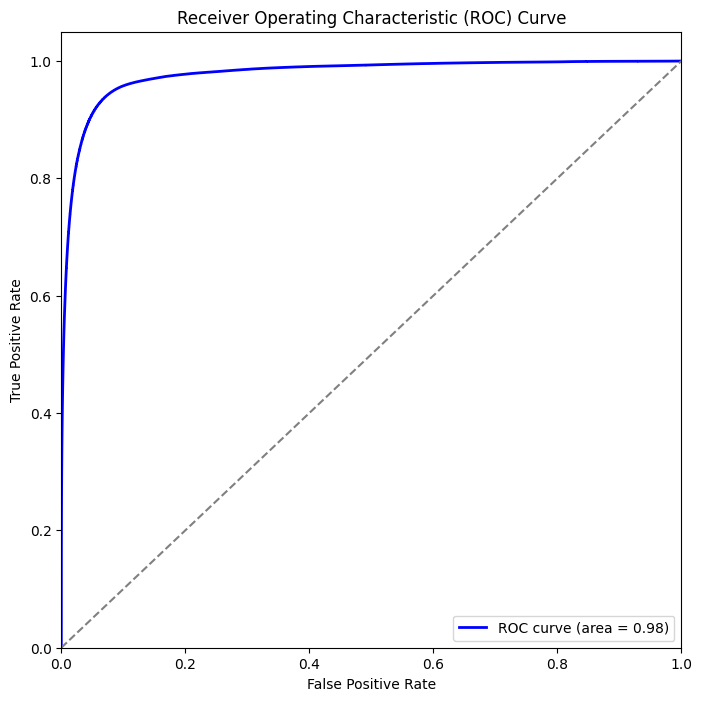

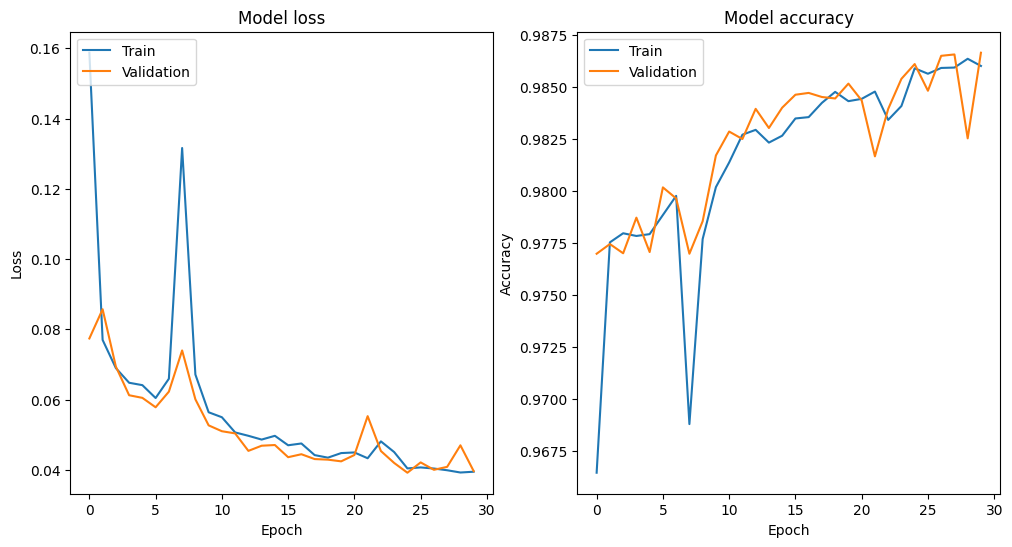

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dense, Layer, Permute, Reshape, Multiply
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.callbacks import EarlyStopping
import xml.etree.ElementTree as ET

from google.colab import drive
drive.mount('/content/drive')

images_path = '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages'
masks_path = '/content/drive/MyDrive/BBox_SSDD/voc_style/Annotations'

if not os.path.exists(images_path):
    raise ValueError(f"Images directory '{images_path}' not found.")

if not os.path.exists(masks_path):
    raise ValueError(f"Masks directory '{masks_path}' not found.")

images = sorted([os.path.join(images_path, file) for file in os.listdir(images_path) if file.endswith('.jpg')])
mask_files = sorted([os.path.join(masks_path, f) for f in os.listdir(masks_path) if f.endswith('.xml')])

print(len(images), len(mask_files))

if len(mask_files) == 0:
    raise ValueError("No mask files found in the specified directory. Please check your mask directory.")

print(f"Found {len(images)} images.")
print(f"Found {len(mask_files)} mask files.")

train_images, test_images, train_masks, test_masks = train_test_split(images, mask_files, test_size=0.4, random_state=42)
val_images, test_images, val_masks, test_masks = train_test_split(test_images, test_masks, test_size=0.5, random_state=42)

def adjust_data(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img, mask)

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images_paths, masks_paths, batch_size=8, image_size=(256, 256)):
        self.images_paths = images_paths
        self.masks_paths = masks_paths
        self.batch_size = batch_size
        self.image_size = image_size

    def __len__(self):
        return len(self.images_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_x = self.images_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.masks_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        x = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.float32)
        y = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.float32)

        for i, (img_path, mask_path) in enumerate(zip(batch_x, batch_y)):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            mask = np.zeros_like(img, dtype=np.uint8)

            tree = ET.parse(mask_path)
            root = tree.getroot()
            for obj in root.findall('object'):
                bndbox = obj.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                cv2.rectangle(mask, (xmin, ymin), (xmax, ymax), (255), thickness=-1)

            img = cv2.resize(img, self.image_size)
            mask = cv2.resize(mask, self.image_size)

            img = np.expand_dims(img, axis=-1)
            mask = np.expand_dims(mask, axis=-1)

            x[i], y[i] = adjust_data(img, mask)

        return x, y

class MultiHeadAttention(Layer):
    def __init__(self, num_heads, head_dim):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.depth = num_heads * head_dim

        self.wq = Dense(self.depth)
        self.wk = Dense(self.depth)
        self.wv = Dense(self.depth)

        self.dense = Dense(self.depth)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.head_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, q, k, v, mask=None):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = self.scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.depth))

        output = self.dense(concat_attention)

        return output, attention_weights

    def scaled_dot_product_attention(self, q, k, v, mask=None):
        matmul_qk = tf.matmul(q, k, transpose_b=True)

        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

        output = tf.matmul(attention_weights, v)

        return output, attention_weights

def hrnet_model_with_multihead_attention(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    maxpool1 = MaxPooling2D()(conv2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(maxpool1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    maxpool2 = MaxPooling2D()(conv4)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(maxpool2)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

    multihead_attention_1 = MultiHeadAttention(num_heads=4, head_dim=64)
    query = tf.reshape(conv6, (tf.shape(conv6)[0], -1, 256))
    key = tf.reshape(conv6, (tf.shape(conv6)[0], -1, 256))
    value = tf.reshape(conv6, (tf.shape(conv6)[0], -1, 256))
    multihead_output_1, _ = multihead_attention_1(query, key, value)
    multihead_output_1 = tf.reshape(multihead_output_1, tf.shape(conv6))
    conv6_attended = tf.keras.layers.add([conv6, multihead_output_1])

    maxpool3 = MaxPooling2D()(conv6_attended)
    conv7 = Conv2D(512, 3, activation='relu', padding='same')(maxpool3)
    conv8 = Conv2D(512, 3, activation='relu', padding='same')(conv7)

    multihead_attention_2 = MultiHeadAttention(num_heads=4, head_dim=128)
    query = tf.reshape(conv8, (tf.shape(conv8)[0], -1, 512))
    key = tf.reshape(conv8, (tf.shape(conv8)[0], -1, 512))
    value = tf.reshape(conv8, (tf.shape(conv8)[0], -1, 512))
    multihead_output_2, _ = multihead_attention_2(query, key, value)
    multihead_output_2 = tf.reshape(multihead_output_2, tf.shape(conv8))
    conv8_attended = tf.keras.layers.add([conv8, multihead_output_2])

    upsample1 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv8_attended)
    concat1 = concatenate([upsample1, conv6], axis=3)
    conv9 = Conv2D(256, 3, activation='relu', padding='same')(concat1)
    conv10 = Conv2D(256, 3, activation='relu', padding='same')(conv9)
    upsample2 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv10)
    concat2 = concatenate([upsample2, conv4], axis=3)
    conv11 = Conv2D(128, 3, activation='relu', padding='same')(concat2)
    conv12 = Conv2D(128, 3, activation='relu', padding='same')(conv11)
    upsample3 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv12)
    concat3 = concatenate([upsample3, conv2], axis=3)
    conv13 = Conv2D(64, 3, activation='relu', padding='same')(concat3)
    conv14 = Conv2D(64, 3, activation='relu', padding='same')(conv13)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv14)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

model_with_multihead_attention = hrnet_model_with_multihead_attention(input_size=(256, 256, 1))

batch_size = 8

train_gen = DataGenerator(train_images, train_masks, batch_size=batch_size)
val_gen = DataGenerator(val_images, val_masks, batch_size=batch_size)
test_gen = DataGenerator(test_images, test_masks, batch_size=batch_size)

history_multihead_attention = model_with_multihead_attention.fit(train_gen,
                                            epochs=75,
                                            validation_data=val_gen,
                                            callbacks=[early_stopping])

y_pred_multihead_attention = model_with_multihead_attention.predict(test_gen)

y_true_flat_multihead_attention = np.concatenate([test_gen[i][1].flatten() for i in range(len(test_gen))])
y_pred_flat_multihead_attention = y_pred_multihead_attention.flatten()

y_pred_binary_multihead_attention = (y_pred_flat_multihead_attention > 0.5).astype(int)

fpr_multihead_attention, tpr_multihead_attention, thresholds_multihead_attention = roc_curve(y_true_flat_multihead_attention, y_pred_flat_multihead_attention)

roc_auc_multihead_attention = auc(fpr_multihead_attention, tpr_multihead_attention)

plt.figure(figsize=(8, 8))
plt.plot(fpr_multihead_attention, tpr_multihead_attention, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_multihead_attention:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_multihead_attention.history['loss'])
plt.plot(history_multihead_attention.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_multihead_attention.history['accuracy'])
plt.plot(history_multihead_attention.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score
from sklearn.metrics import precision_score, recall_score
import math

def compute_iou_masks(y_true, y_pred):
    intersection_area = 0
    union_area = 0

    for mask_true, mask_pred in zip(y_true, y_pred):
        intersection = np.logical_and(mask_true, mask_pred)
        union = np.logical_or(mask_true, mask_pred)

        intersection_area += np.sum(intersection)
        union_area += np.sum(union)

    if union_area == 0:
        return 0

    return intersection_area / union_area

def compute_map_boxes(y_true, y_pred):
    avg_precision = 0

    for i in range(len(y_true)):
        y_true_flat = y_true[i].flatten()
        y_pred_flat = y_pred[i].flatten()

        precision, recall, _ = precision_recall_curve(y_true_flat, y_pred_flat)

        avg_precision += average_precision_score(y_true_flat, y_pred_flat)

    return avg_precision / len(y_true)


def compute_psnr_boxes(y_true, y_pred):
    mse_total = 0
    num_samples = len(y_true)

    for box_true, box_pred in zip(y_true, y_pred):
        mse = np.mean((box_true - box_pred) ** 2)
        mse_total += mse

    mse_avg = mse_total / num_samples

    if mse_avg == 0:
        return float('inf')
    else:
        max_pixel = 1.0
        return 20 * math.log10(max_pixel / math.sqrt(mse_avg))


def compute_dice_boxes(y_true, y_pred):
    dice_scores = []

    for box_true, box_pred in zip(y_true, y_pred):
        intersection = np.sum(box_true * box_pred)
        dice = (2. * intersection) / (np.sum(box_true) + np.sum(box_pred))
        dice_scores.append(dice)

    return np.mean(dice_scores)


test_gen_no_shuffle = DataGenerator(test_images, test_masks, batch_size=batch_size)

y_true_multihead_attention = []
for i in range(len(test_gen_no_shuffle)):
    _, batch_y = test_gen_no_shuffle[i]
    y_true_multihead_attention.extend(batch_y)

y_true_multihead_attention = np.array(y_true_multihead_attention)

if y_pred_multihead_attention.shape != y_true_multihead_attention.shape:
    raise ValueError("Shapes of y_pred_new and y_true_new are not compatible.")


iou_boxes_multihead_attention = compute_iou_masks(y_true_multihead_attention, y_pred_multihead_attention)
mAP_boxes_multihead_attention = compute_map_boxes(y_true_multihead_attention, y_pred_multihead_attention)
psnr_boxes_multihead_attention = compute_psnr_boxes(y_true_multihead_attention, y_pred_multihead_attention)
dice_boxes_multihead_attention = compute_dice_boxes(y_true_multihead_attention, y_pred_multihead_attention)

print("Intersection over Union (IoU) for Segmentation Boxes for the multihead attention model:", iou_boxes_multihead_attention)
print("Mean Average Precision (mAP) for Segmentation Boxes for the multihead attention model:", mAP_boxes_multihead_attention)
print("Peak Signal to Noise Ratio (PSNR) for Segmentation Boxes for the multihead attention model:", psnr_boxes_multihead_attention)
print("Dice Coefficient for Segmentation Boxes for the multihead attention model:", dice_boxes_multihead_attention)

Intersection over Union (IoU) for Segmentation Boxes for the multihead attention model: 0.02524810001767915
Mean Average Precision (mAP) for Segmentation Boxes for the multihead attention model: 0.8567794301390204
Peak Signal to Noise Ratio (PSNR) for Segmentation Boxes for the multihead attention model: 19.144625538957985
Dice Coefficient for Segmentation Boxes for the multihead attention model: 0.5296098750113698


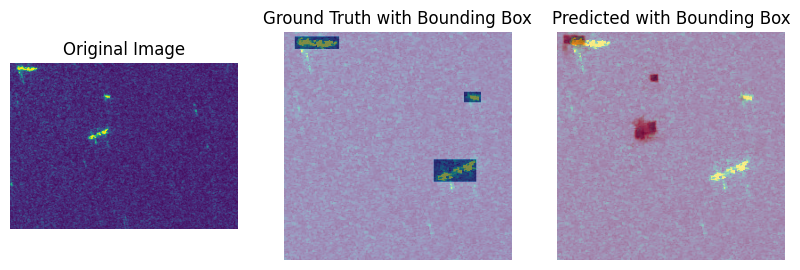

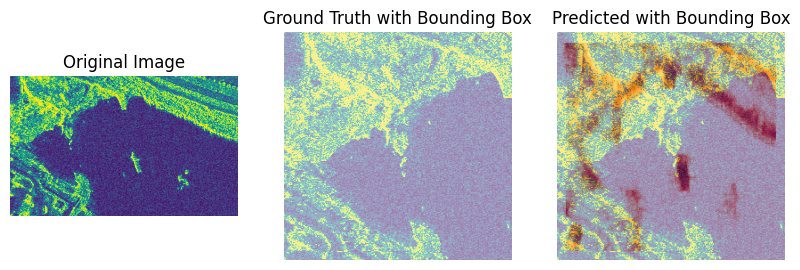

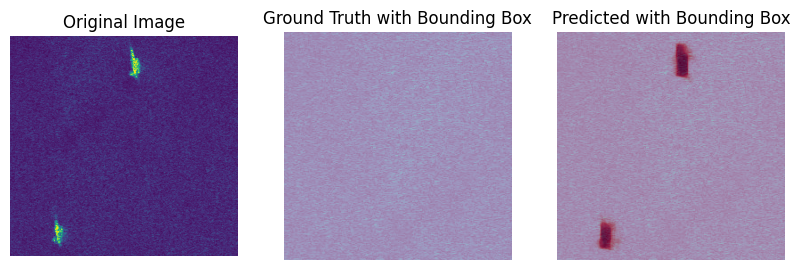

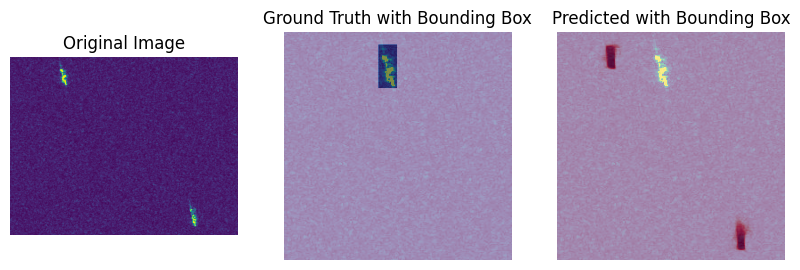

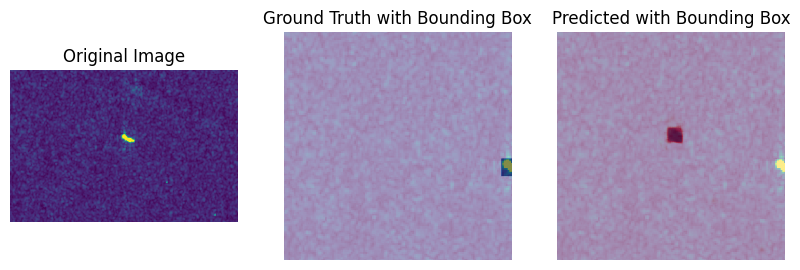

In [ ]:
import matplotlib.pyplot as plt

def create_segmentation_masks(xml_path, image_size):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    mask = np.zeros(image_size, dtype=np.uint8)

    for obj in root.findall('object'):
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

        mask[ymin:ymax, xmin:xmax] = 1

    return mask

def visualize_bounding_boxes(images, masks, predictions):
    num_images = len(images)

    for i in range(num_images):
        image = images[i]
        mask = masks[i]
        prediction = predictions[i]

        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
        mask = create_segmentation_masks(mask, (256, 256))
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(image)
        plt.imshow(mask, alpha=0.5, cmap='Blues')
        plt.title("Ground Truth with Bounding Box")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(image)
        plt.imshow(prediction, alpha=0.5, cmap='Reds')
        plt.title("Predicted with Bounding Box")
        plt.axis('off')

        plt.show()

visualize_bounding_boxes(test_images[:5], test_masks[:5], y_pred_multihead_attention[:5])

HRNet with Cross Modal attention

Mounted at /content/drive
1160 1160
Found 1160 images.
Found 1160 mask files.
Epoch 1/75
87/87 [==============================] - 273s 3s/step - loss: 0.1994 - accuracy: 0.9690 - val_loss: 0.1524 - val_accuracy: 0.9770
Epoch 2/75
87/87 [==============================] - 65s 752ms/step - loss: 0.0714 - accuracy: 0.9787 - val_loss: 0.0698 - val_accuracy: 0.9837
Epoch 3/75
87/87 [==============================] - 65s 748ms/step - loss: 0.0534 - accuracy: 0.9825 - val_loss: 0.0455 - val_accuracy: 0.9844
Epoch 4/75
87/87 [==============================] - 65s 748ms/step - loss: 0.0483 - accuracy: 0.9836 - val_loss: 0.0452 - val_accuracy: 0.9856
Epoch 5/75
87/87 [==============================] - 66s 755ms/step - loss: 0.0556 - accuracy: 0.9827 - val_loss: 0.0434 - val_accuracy: 0.9850
Epoch 6/75
87/87 [==============================] - 65s 743ms/step - loss: 0.0416 - accuracy: 0.9854 - val_loss: 0.0370 - val_accuracy: 0.9869
Epoch 7/75
87/87 [==============================] - 68s 788ms/step

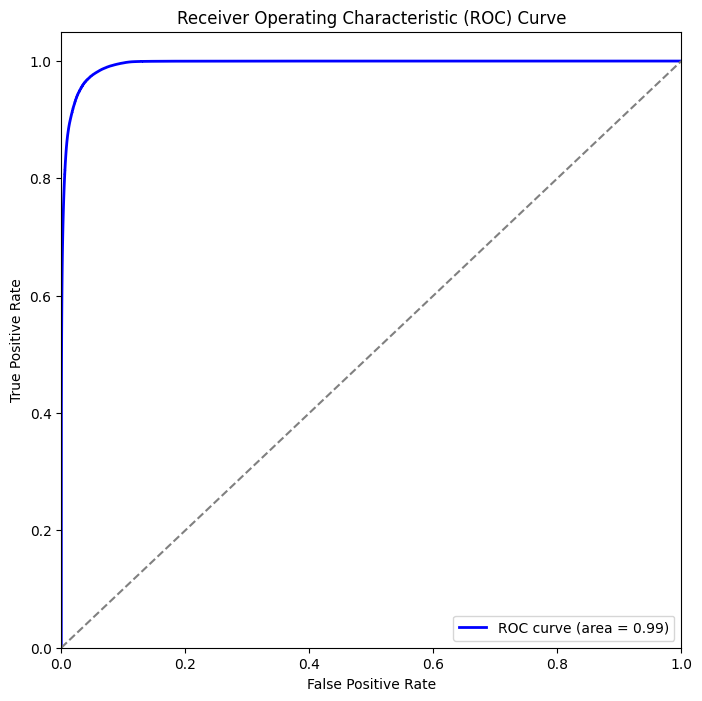

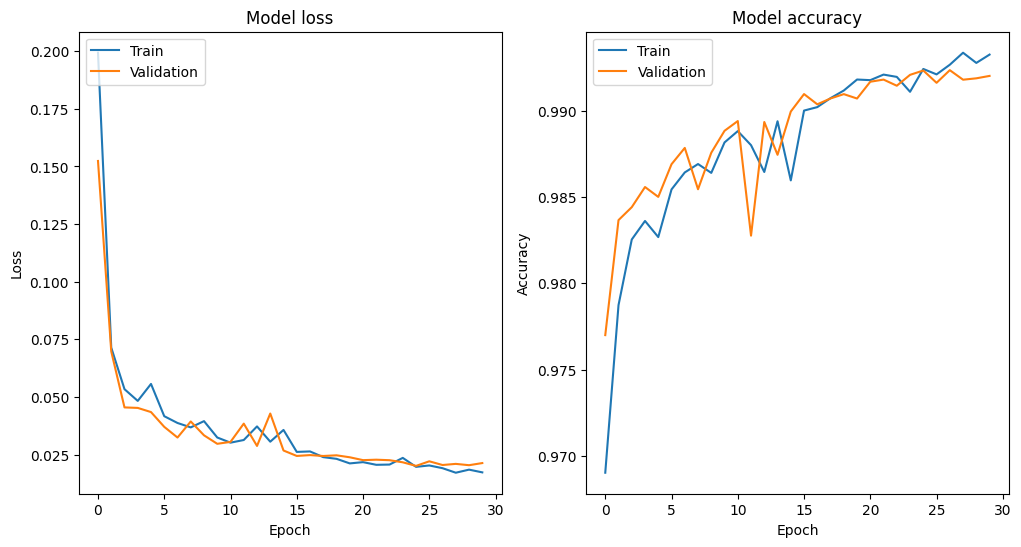

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dense, Layer, Permute, Reshape, Multiply
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.callbacks import EarlyStopping
import xml.etree.ElementTree as ET

from google.colab import drive
drive.mount('/content/drive')

images_path = '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages'
masks_path = '/content/drive/MyDrive/BBox_SSDD/voc_style/Annotations'

if not os.path.exists(images_path):
    raise ValueError(f"Images directory '{images_path}' not found.")

if not os.path.exists(masks_path):
    raise ValueError(f"Masks directory '{masks_path}' not found.")

images = sorted([os.path.join(images_path, file) for file in os.listdir(images_path) if file.endswith('.jpg')])
mask_files = sorted([os.path.join(masks_path, f) for f in os.listdir(masks_path) if f.endswith('.xml')])

print(len(images), len(mask_files))

if len(mask_files) == 0:
    raise ValueError("No mask files found in the specified directory. Please check your mask directory.")

print(f"Found {len(images)} images.")
print(f"Found {len(mask_files)} mask files.")

train_images, test_images, train_masks, test_masks = train_test_split(images, mask_files, test_size=0.4, random_state=42)
val_images, test_images, val_masks, test_masks = train_test_split(test_images, test_masks, test_size=0.5, random_state=42)

def adjust_data(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img, mask)

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images_paths, masks_paths, batch_size=8, image_size=(256, 256)):
        self.images_paths = images_paths
        self.masks_paths = masks_paths
        self.batch_size = batch_size
        self.image_size = image_size

    def __len__(self):
        return len(self.images_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_x = self.images_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.masks_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        x = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.float32)
        y = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.float32)

        for i, (img_path, mask_path) in enumerate(zip(batch_x, batch_y)):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            mask = np.zeros_like(img, dtype=np.uint8)

            tree = ET.parse(mask_path)
            root = tree.getroot()
            for obj in root.findall('object'):
                bndbox = obj.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                cv2.rectangle(mask, (xmin, ymin), (xmax, ymax), (255), thickness=-1)

            img = cv2.resize(img, self.image_size)
            mask = cv2.resize(mask, self.image_size)

            img = np.expand_dims(img, axis=-1)
            mask = np.expand_dims(mask, axis=-1)

            x[i], y[i] = adjust_data(img, mask)

        return x, y

class CrossModalAttention(Layer):
    def __init__(self, num_heads, head_dim):
        super(CrossModalAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.depth = num_heads * head_dim

        self.wq = Dense(self.depth)
        self.wk = Dense(self.depth)
        self.wv = Dense(self.depth)

        self.dense = Dense(self.depth)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.head_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, q, k, v, mask=None):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = self.scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.depth))

        output = self.dense(concat_attention)

        return output, attention_weights

    def scaled_dot_product_attention(self, q, k, v, mask=None):
        matmul_qk = tf.matmul(q, k, transpose_b=True)

        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

        output = tf.matmul(attention_weights, v)

        return output, attention_weights

def hrnet_model_with_crossmodal_attention(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    maxpool1 = MaxPooling2D()(conv2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(maxpool1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    maxpool2 = MaxPooling2D()(conv4)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(maxpool2)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

    crossmodal_attention_1 = CrossModalAttention(num_heads=4, head_dim=64)
    query = tf.reshape(conv6, (tf.shape(conv6)[0], -1, 256))
    key = tf.reshape(conv6, (tf.shape(conv6)[0], -1, 256))
    value = tf.reshape(conv6, (tf.shape(conv6)[0], -1, 256))
    crossmodal_output_1, _ = crossmodal_attention_1(query, key, value)
    crossmodal_output_1 = tf.reshape(crossmodal_output_1, tf.shape(conv6))
    conv6_attended = tf.keras.layers.add([conv6, crossmodal_output_1])

    maxpool3 = MaxPooling2D()(conv6_attended)
    conv7 = Conv2D(512, 3, activation='relu', padding='same')(maxpool3)
    conv8 = Conv2D(512, 3, activation='relu', padding='same')(conv7)

    crossmodal_attention_2 = CrossModalAttention(num_heads=4, head_dim=128)
    query = tf.reshape(conv8, (tf.shape(conv8)[0], -1, 512))
    key = tf.reshape(conv8, (tf.shape(conv8)[0], -1, 512))
    value = tf.reshape(conv8, (tf.shape(conv8)[0], -1, 512))
    crossmodal_output_2, _ = crossmodal_attention_2(query, key, value)
    crossmodal_output_2 = tf.reshape(crossmodal_output_2, tf.shape(conv8))
    conv8_attended = tf.keras.layers.add([conv8, crossmodal_output_2])

    upsample1 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv8_attended)
    concat1 = concatenate([upsample1, conv6], axis=3)
    conv9 = Conv2D(256, 3, activation='relu', padding='same')(concat1)
    conv10 = Conv2D(256, 3, activation='relu', padding='same')(conv9)
    upsample2 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv10)
    concat2 = concatenate([upsample2, conv4], axis=3)
    conv11 = Conv2D(128, 3, activation='relu', padding='same')(concat2)
    conv12 = Conv2D(128, 3, activation='relu', padding='same')(conv11)
    upsample3 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv12)
    concat3 = concatenate([upsample3, conv2], axis=3)
    conv13 = Conv2D(64, 3, activation='relu', padding='same')(concat3)
    conv14 = Conv2D(64, 3, activation='relu', padding='same')(conv13)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv14)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

model_with_crossmodal_attention = hrnet_model_with_crossmodal_attention(input_size=(256, 256, 1))

batch_size = 8

train_gen = DataGenerator(train_images, train_masks, batch_size=batch_size)
val_gen = DataGenerator(val_images, val_masks, batch_size=batch_size)
test_gen = DataGenerator(test_images, test_masks, batch_size=batch_size)

history_crossmodal_attention = model_with_crossmodal_attention.fit(train_gen,
                                            epochs=75,
                                            validation_data=val_gen,
                                            callbacks=[early_stopping])

y_pred_crossmodal_attention = model_with_crossmodal_attention.predict(test_gen)

y_true_flat_crossmodal_attention = np.concatenate([test_gen[i][1].flatten() for i in range(len(test_gen))])
y_pred_flat_crossmodal_attention = y_pred_crossmodal_attention.flatten()

y_pred_binary_crossmodal_attention = (y_pred_flat_crossmodal_attention > 0.5).astype(int)

fpr_crossmodal_attention, tpr_crossmodal_attention, thresholds_crossmodal_attention = roc_curve(y_true_flat_crossmodal_attention, y_pred_flat_crossmodal_attention)

roc_auc_crossmodal_attention = auc(fpr_crossmodal_attention, tpr_crossmodal_attention)

plt.figure(figsize=(8, 8))
plt.plot(fpr_crossmodal_attention, tpr_crossmodal_attention, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_crossmodal_attention:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_crossmodal_attention.history['loss'])
plt.plot(history_crossmodal_attention.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_crossmodal_attention.history['accuracy'])
plt.plot(history_crossmodal_attention.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [3]:
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score
from sklearn.metrics import precision_score, recall_score
import math

def compute_iou_masks(y_true, y_pred):
    intersection_area = 0
    union_area = 0

    for mask_true, mask_pred in zip(y_true, y_pred):
        intersection = np.logical_and(mask_true, mask_pred)
        union = np.logical_or(mask_true, mask_pred)

        intersection_area += np.sum(intersection)
        union_area += np.sum(union)

    if union_area == 0:
        return 0

    return intersection_area / union_area

def compute_map_boxes(y_true, y_pred):
    avg_precision = 0

    for i in range(len(y_true)):
        y_true_flat = y_true[i].flatten()
        y_pred_flat = y_pred[i].flatten()

        precision, recall, _ = precision_recall_curve(y_true_flat, y_pred_flat)

        avg_precision += average_precision_score(y_true_flat, y_pred_flat)

    return avg_precision / len(y_true)


def compute_psnr_boxes(y_true, y_pred):
    mse_total = 0
    num_samples = len(y_true)

    for box_true, box_pred in zip(y_true, y_pred):
        mse = np.mean((box_true - box_pred) ** 2)
        mse_total += mse

    mse_avg = mse_total / num_samples

    if mse_avg == 0:
        return float('inf')
    else:
        max_pixel = 1.0
        return 20 * math.log10(max_pixel / math.sqrt(mse_avg))


def compute_dice_boxes(y_true, y_pred):
    dice_scores = []

    for box_true, box_pred in zip(y_true, y_pred):
        intersection = np.sum(box_true * box_pred)
        dice = (2. * intersection) / (np.sum(box_true) + np.sum(box_pred))
        dice_scores.append(dice)

    return np.mean(dice_scores)

test_gen_no_shuffle = DataGenerator(test_images, test_masks, batch_size=batch_size)

y_true_crossmodal_attention = []
for i in range(len(test_gen_no_shuffle)):
    _, batch_y = test_gen_no_shuffle[i]
    y_true_crossmodal_attention.extend(batch_y)

y_true_crossmodal_attention = np.array(y_true_crossmodal_attention)

if y_pred_crossmodal_attention.shape != y_true_crossmodal_attention.shape:
    raise ValueError("Shapes of y_pred_new and y_true_new are not compatible.")


iou_boxes_crossmodal_attention = compute_iou_masks(y_true_crossmodal_attention, y_pred_crossmodal_attention)
mAP_boxes_crossmodal_attention = compute_map_boxes(y_true_crossmodal_attention, y_pred_crossmodal_attention)
psnr_boxes_crossmodal_attention = compute_psnr_boxes(y_true_crossmodal_attention, y_pred_crossmodal_attention)
dice_boxes_crossmodal_attention = compute_dice_boxes(y_true_crossmodal_attention, y_pred_crossmodal_attention)

print("Intersection over Union (IoU) for Segmentation Boxes for the crossmodal attention model:", iou_boxes_crossmodal_attention)
print("Mean Average Precision (mAP) for Segmentation Boxes for the crossmodal attention model:", mAP_boxes_crossmodal_attention)
print("Peak Signal to Noise Ratio (PSNR) for Segmentation Boxes for the crossmodal attention model:", psnr_boxes_crossmodal_attention)
print("Dice Coefficient for Segmentation Boxes for the crossmodal attention model:", dice_boxes_crossmodal_attention)

Intersection over Union (IoU) for Segmentation Boxes for the crossmodal attention model: 0.02525218239253609
Mean Average Precision (mAP) for Segmentation Boxes for the crossmodal attention model: 0.9376498900053322
Peak Signal to Noise Ratio (PSNR) for Segmentation Boxes for the crossmodal attention model: 20.844121278624094
Dice Coefficient for Segmentation Boxes for the crossmodal attention model: 0.7803689156210796


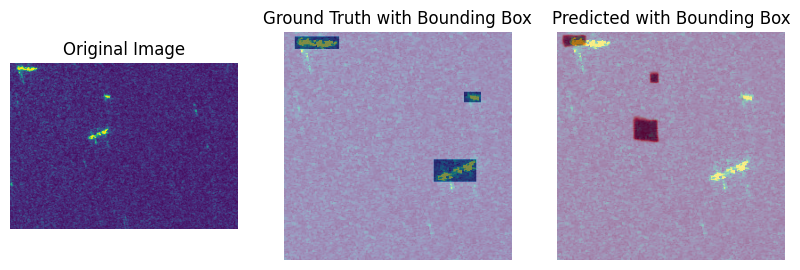

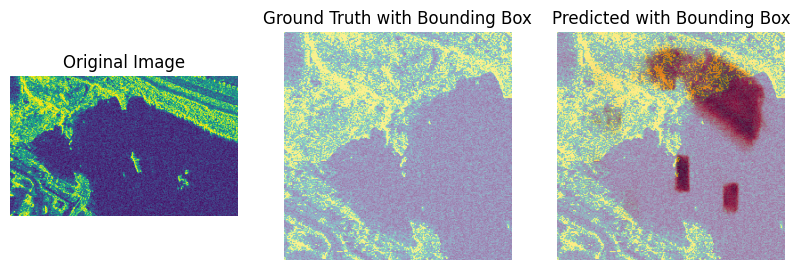

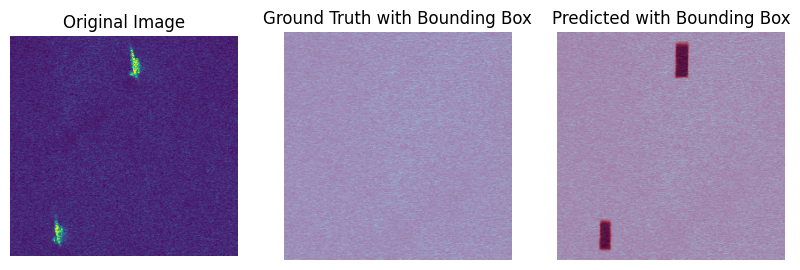

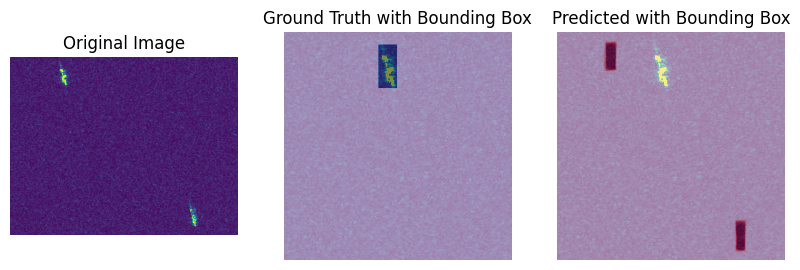

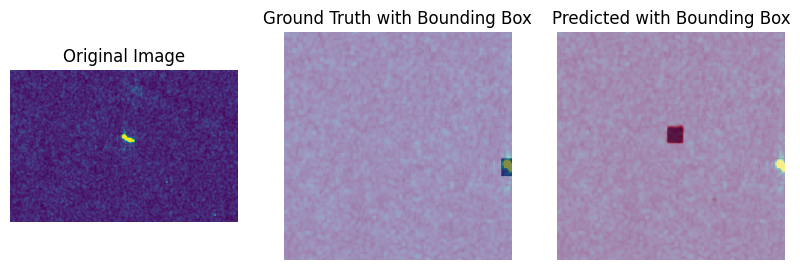

In [4]:
import matplotlib.pyplot as plt

def create_segmentation_masks(xml_path, image_size):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    mask = np.zeros(image_size, dtype=np.uint8)

    for obj in root.findall('object'):
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

        mask[ymin:ymax, xmin:xmax] = 1

    return mask

def visualize_bounding_boxes(images, masks, predictions):
    num_images = len(images)

    for i in range(num_images):
        image = images[i]
        mask = masks[i]
        prediction = predictions[i]

        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
        mask = create_segmentation_masks(mask, (256, 256))
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(image)
        plt.imshow(mask, alpha=0.5, cmap='Blues')
        plt.title("Ground Truth with Bounding Box")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(image)
        plt.imshow(prediction, alpha=0.5, cmap='Reds')
        plt.title("Predicted with Bounding Box")
        plt.axis('off')

        plt.show()

visualize_bounding_boxes(test_images[:5], test_masks[:5], y_pred_crossmodal_attention[:5])